<a href="https://colab.research.google.com/github/AzamH-UM/CYP3A4/blob/main/CYP3A4_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XAI Example with CYP3A4 dataset



Sources:

*   https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
*   In silico prediction of cytochrome P450-drug interaction: QSARs for CYP3A4 and CYP2C9.

*   https://www.rdkit.org/docs/GettingStartedInPython.html
*   https://github.com/SeldonIO/alibi







In [1]:
#install deepchem and rdkit
#!pip install --pre deepchem
!pip install rdkit-pypi -qqq
!pip install alibi
!pip install alibi[shap]
import tensorflow as tf
tf.__version__
#tf.compat.v1.disable_eager_execution()




     |████████████████████████████████| 22.5 MB 1.4 MB/s 
     |████████████████████████████████| 398 kB 7.9 MB/s 
     |████████████████████████████████| 4.0 MB 14.7 MB/s 
     |████████████████████████████████| 28.0 MB 53.5 MB/s 
     |████████████████████████████████| 462 kB 11.6 MB/s 
     |████████████████████████████████| 77 kB 4.5 MB/s 
     |████████████████████████████████| 596 kB 34.9 MB/s 
     |████████████████████████████████| 895 kB 38.7 MB/s 
     |████████████████████████████████| 6.6 MB 10.4 MB/s 
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052158 sha256=160f39aca96a6790ec7bff333be30e44b62f6173c4a33456dbcb24c07c747a03
  Stored in directory: /root/.cache/pip/wheels/b6/09/83/36dd0224ce32dcdf5e218b36362235ca2e50cece60a966ae1b
Successfully built spacy-lookups-data
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     

'2.8.0'

In [2]:
#Python imports 
#Imports
import os
import sys
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load in Data from Excel File

In [3]:
#Get datasets from github
!git clone 'https://github.com/AzamH-UM/CYP3A4.git'

Cloning into 'CYP3A4'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.


In [4]:
#Load in dataset
CYP3A4_df = pd.read_excel('/content/CYP3A4/CYP3A4.xlsx', header = 0, index_col = 0)

#Drop in rows containing unneccesary properties
CYP3A4_df.drop(CYP3A4_df.columns.difference(['SMILES','Class', 'Class code', 'Type']), axis = 1, inplace=True)

#Scale class code from 0 to 1 instead of 1 to 2 (0: active, 1: inactive)
CYP3A4_df['Class code'] = CYP3A4_df['Class code'].apply(lambda x: int(x) - 1)

#Print first 9 entries
pd.set_option('display.width', 1500)
print(CYP3A4_df.head(9))


                                                   SMILES     Class  Class code   Type
ID                                                                                    
Tr1                           CN(C)c1nc(nc(n1)N(C)C)N(C)C  Inactive           1  train
Tr10                              CN(C)C(=O)N=NC(=O)N(C)C  Inactive           1  train
Tr1000     CC(=O)NS(=O)(=O)c1ccc(NC(=S)NC(=O)C(C)(C)C)cc1  Inactive           1  train
Tr1001                C1CC2(CCN1)CN(C2)c3cccc(c3)c4ccccc4  Inactive           1  train
Tr1002          CCN1CCC[C@H](C1)OC(=O)C(c2ccccc2)c3ccccc3    Active           0  train
Tr5961  [O-][N+](=O)c1cc(\C=N/OC(=O)c2cccc(Cl)c2)ccc1N...  Inactive           1   test
Tr2396  [O-][N+](=O)c1cc(\C=N\N2CCN(CC2)C3c4ccccc4c5cc...  Inactive           1   test
Tr1003       Cc1nc2ncnn2c(O)c1NC(=O)CC34CC5CC(CC(C5)C3)C4  Inactive           1  train
Tr1004  FC(F)(F)c1cc(CN2CC3(CCN(CC3)C(=O)c4csnn4)C2)cc...  Inactive           1  train


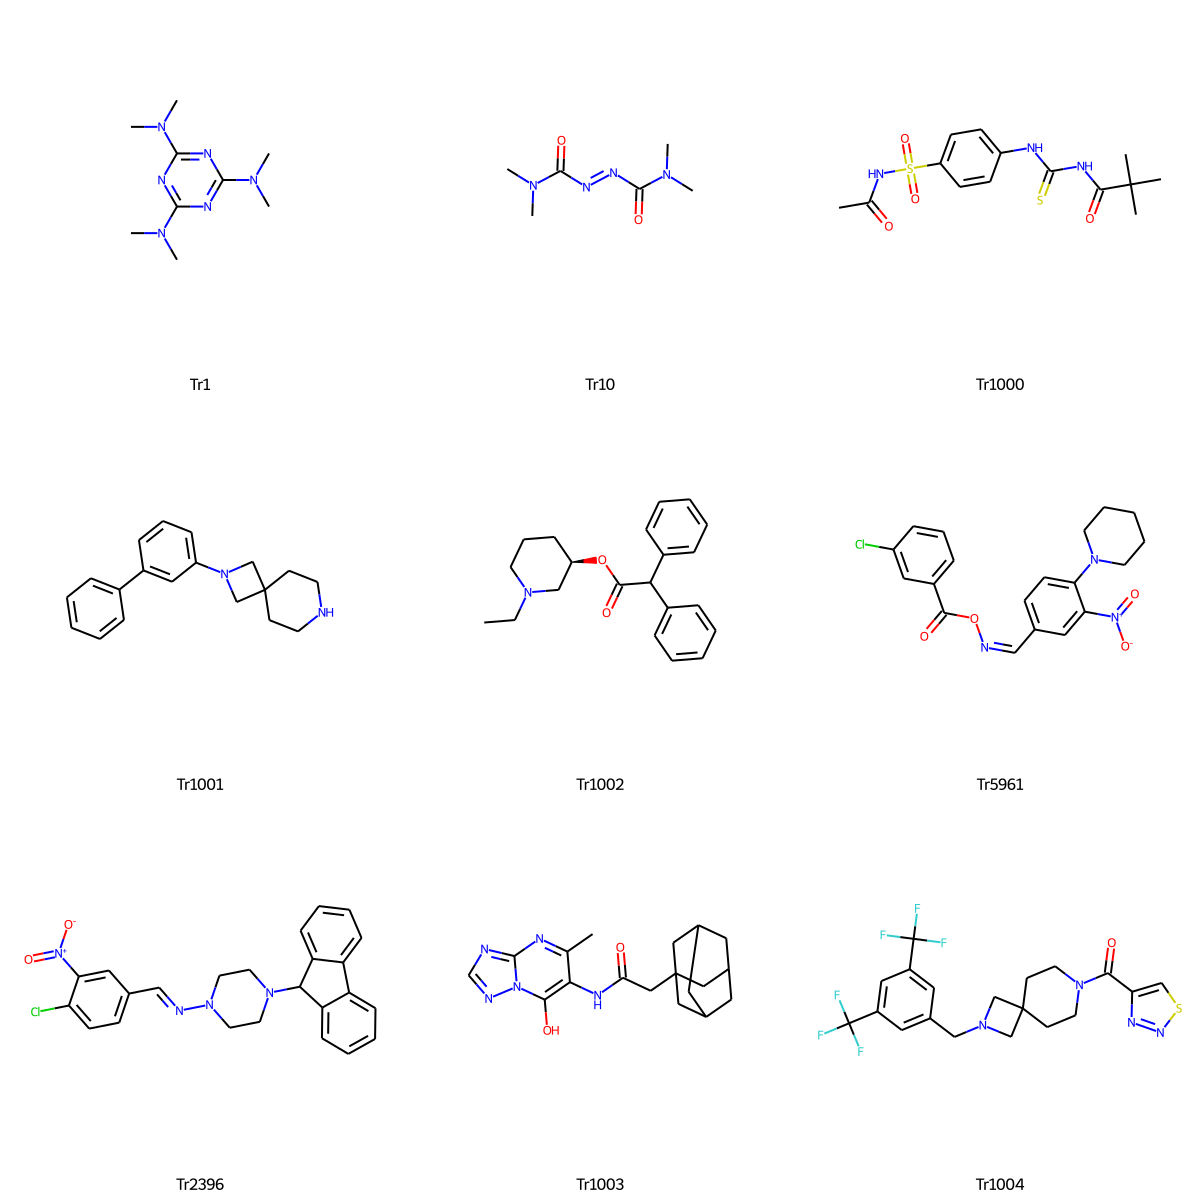

In [5]:
#Create mol file for each smiles string for fingerprint generation
mols = [Chem.MolFromSmiles(smiles) for smiles in CYP3A4_df['SMILES']]

#Draw first 9 entries
Draw.MolsToGridImage(mols[0:9], subImgSize=(400,400), legends = list(CYP3A4_df.index)[0:9])

In [6]:
#Generate Morgan Fingerprints for ligands
cutoff = 2
bit_infos = []
fingerprints = []
for mol in mols:
  bit_info = {}
  fp = AllChem.GetMorganFingerprintAsBitVect(mol, cutoff, bitInfo=bit_info)
  fingerprints.append(fp)
  bit_infos.append(bit_info)         

#add fingerprint and bitvectors to dataframe
CYP3A4_df['mols'] = mols
CYP3A4_df['fingerprint'] = fingerprints
CYP3A4_df['bit_info'] = bit_infos

print(CYP3A4_df.head(10))

                                                   SMILES     Class  Class code   Type                                              mols                                        fingerprint                                           bit_info
ID                                                                                                                                                                                                                                            
Tr1                           CN(C)c1nc(nc(n1)N(C)C)N(C)C  Inactive           1  train  <rdkit.Chem.rdchem.Mol object at 0x7f575485c440>  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  {378: ((4, 0), (6, 0), (8, 0)), 380: ((5, 2), ...
Tr10                              CN(C)C(=O)N=NC(=O)N(C)C  Inactive           1  train  <rdkit.Chem.rdchem.Mol object at 0x7f5754884490>  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  {267: ((3, 1), (7, 1)), 521: ((5, 1), (6, 1)),...
Tr1000     CC(=O)NS(=O)(=O)c1ccc(NC(=S)NC(=O

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 

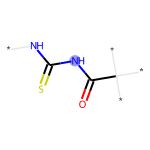

In [7]:
#Plot different fingerprints for Tr1000
fp_1000 = CYP3A4_df['fingerprint']['Tr1000']
bit_info_1000 = CYP3A4_df['bit_info']['Tr1000']
fp_1000_list = fp_1000.ToList()
print(fp_1000_list)
print(bit_info_1000)
print('Fingerprint Length', len(fp_1000_list))
print('first fingerprint hit:' , fp_1000_list.index(1))
svg1 = Draw.DrawMorganBit(mols[2], 245, bit_info_1000, useSVG=True)
svg2 = Draw.DrawMorganBit(mols[2], 270, bit_info_1000, useSVG=True)
svg3 = Draw.DrawMorganBit(mols[2], 283, bit_info_1000, useSVG=True)

svg3

# Split into Training and Testing Datasets

In [8]:
#Split into train and test datasets according to given split
train_val_df = CYP3A4_df.loc[CYP3A4_df['Type'] == 'train']
test_df = CYP3A4_df.loc[CYP3A4_df['Type'] == 'test']

def get_np_arrays(df):
  x = np.array(list(df['fingerprint']),dtype='float')
  y = np.array(list(df['Class code']),dtype='float')
  ids = list(df.index)
  return x, y, ids

                    
#use sklearn utility to split train and val sets
train_df, val_df = train_test_split(train_val_df, test_size=0.2)

train_x, train_y, train_ids = get_np_arrays(train_df)
val_x, val_y, val_ids = get_np_arrays(val_df)
test_x, test_y, test_ids = get_np_arrays(test_df)
full_x, full_y, full_ids = get_np_arrays(CYP3A4_df)

print(len(train_x))
print(len(val_x))
print(len(test_x))

5107
1277
2737


# Train model

In [33]:
#Define metrics
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

#Define model
dropout = .5

model = keras.Sequential([
	keras.layers.Dense(10, activation='relu', input_shape=(train_x.shape[-1],)),
	keras.layers.Dropout(dropout),
	keras.layers.Dense(10, activation='relu'),
	keras.layers.Dropout(dropout),
	keras.layers.Dense(1, activation='sigmoid')])



model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=METRICS)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                20490     
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 20,611
Trainable params: 20,611
Non-trainable params: 0
_________________________________________________________________


In [34]:
EPOCHS = 80
BATCH_SIZE = 1000

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [35]:
print(model.predict(train_x[:10]))
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

[[0.39522868]
 [0.49369845]
 [0.44458324]
 [0.47785178]
 [0.46254843]
 [0.46790475]
 [0.443854  ]
 [0.4768506 ]
 [0.47475407]
 [0.4820587 ]]


In [36]:
history = model.fit(
    train_x,
    train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_x, val_y))

Epoch 1/80
6/6 [==============================] - 3s 215ms/step - loss: 0.7163 - tp: 857.0000 - fp: 586.0000 - tn: 1441.0000 - fn: 2223.0000 - accuracy: 0.4500 - precision: 0.5939 - recall: 0.2782 - auc: 0.5099 - prc: 0.6069 - val_loss: 0.6958 - val_tp: 179.0000 - val_fp: 116.0000 - val_tn: 395.0000 - val_fn: 587.0000 - val_accuracy: 0.4495 - val_precision: 0.6068 - val_recall: 0.2337 - val_auc: 0.5356 - val_prc: 0.6180
Epoch 2/80
6/6 [==============================] - 0s 26ms/step - loss: 0.6952 - tp: 1808.0000 - fp: 1057.0000 - tn: 970.0000 - fn: 1272.0000 - accuracy: 0.5440 - precision: 0.6311 - recall: 0.5870 - auc: 0.5513 - prc: 0.6313 - val_loss: 0.6886 - val_tp: 505.0000 - val_fp: 273.0000 - val_tn: 238.0000 - val_fn: 261.0000 - val_accuracy: 0.5818 - val_precision: 0.6491 - val_recall: 0.6593 - val_auc: 0.5785 - val_prc: 0.6468
Epoch 3/80
6/6 [==============================] - 0s 26ms/step - loss: 0.6873 - tp: 2254.0000 - fp: 1281.0000 - tn: 746.0000 - fn: 826.0000 - accuracy: 

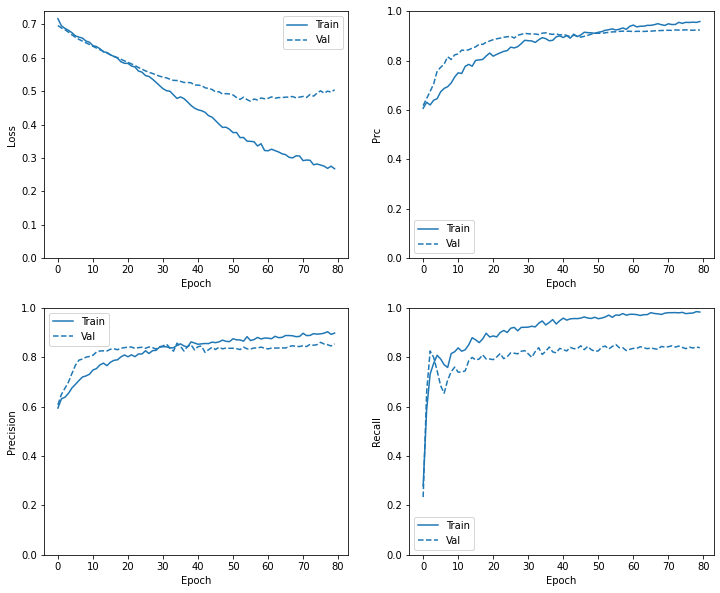

In [37]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();
  
plot_metrics(history)

# Evaluate


In [38]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  print('pass')
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Inactive Found (True Negatives): ', cm[0][0])
  print('Inactive labeled Active (False Positives): ', cm[0][1])
  print('Active labled Inactive (False Negatives): ', cm[1][0])
  print('Active Found (True Positives): ', cm[1][1])
  print('Total Active Compounds: ', np.sum(cm[1]))

loss :  0.5024219751358032
tp :  1373.0
fp :  264.0
tn :  824.0
fn :  276.0
accuracy :  0.8027036786079407
precision :  0.8387293815612793
recall :  0.8326258063316345
auc :  0.8842458724975586
prc :  0.9191904664039612

pass
Inactive Found (True Negatives):  824
Inactive labeled Active (False Positives):  264
Active labled Inactive (False Negatives):  276
Active Found (True Positives):  1373
Total Active Compounds:  1649


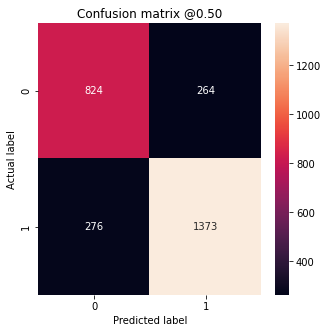

In [39]:
test_predictions_baseline = model.predict(test_x, batch_size=BATCH_SIZE)
baseline_results = model.evaluate(test_x, test_y,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_y, test_predictions_baseline)

# Visuallize with Integrated Gradients


Integrated gradients from Alibi


In [40]:
from alibi.explainers import IntegratedGradients
ig  = IntegratedGradients(model,
                          layer=None,
                          target_fn=None,
                          method="gausslegendre",
                          n_steps=50,
                          internal_batch_size=100)

In [41]:
def get_gradient(x, y):

  explanation = ig.explain(np.expand_dims(np.array(x), 0),
                         baselines=None,
                         target=np.expand_dims(np.array(y), 0))

  attributions = explanation.attributions[0]
  return attributions


In [42]:
#np.expand_dims(np.array(x), 0)
#Cilostazol smiles string: O=C1CCc2c(N1)ccc(c2)OCCCCc1nnnn1C1CCCCC1
Cilostazol_smile = 'O=C1CCc2c(N1)ccc(c2)OCCCCc1nnnn1C1CCCCC1'
Cilostazol_mol = Chem.MolFromSmiles(Cilostazol_smile)
Cilostazol_bit_info = {}
Cilostazol_fp = AllChem.GetMorganFingerprintAsBitVect(Cilostazol_mol, 2, bitInfo=Cilostazol_bit_info)
print(model.predict(np.expand_dims(np.array(Cilostazol_fp), 0)))
Cilostazol_attributions = get_gradient(Cilostazol_fp, 0)[0]

nifedipine_smile = 'CC1=C(C(C(=C(N1)C)C(=O)OC)C2=CC=CC=C2[N+](=O)[O-])C(=O)OC'
nifedipine_mol = Chem.MolFromSmiles(nifedipine_smile)
nifedipine_bit_info = {}
nifedipine_fp = AllChem.GetMorganFingerprintAsBitVect(nifedipine_mol, 2, bitInfo=nifedipine_bit_info)
print(model.predict(np.expand_dims(np.array(nifedipine_fp), 0)))
nifedipine_attributions = get_gradient(nifedipine_fp, 0)[0]


[[0.46492434]]
[[0.03913465]]


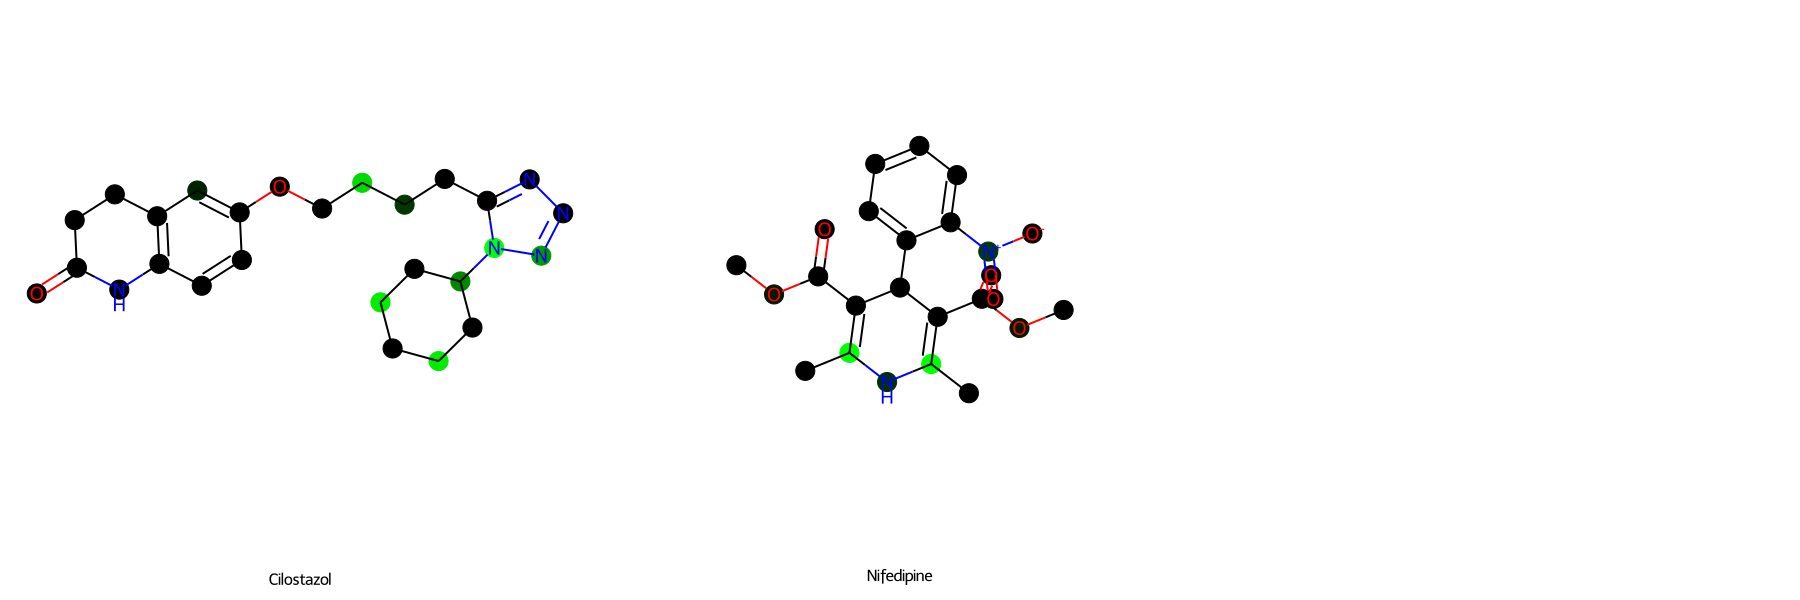

In [43]:
#Color in by contributions

def atom_attribution(attributions, bit_info):
  atom_attr = dict()

  for feature, attr in enumerate(attributions):
    if feature in bit_info:
      for atom, cutoff in bit_info[feature]:
        if atom not in atom_attr:
          atom_attr[atom] = 0
        atom_attr[atom] += attr
  

  return atom_attr

def normalize_atom_attribution(atom_attr):
  norm_atom_attr = dict()
  min_val = min(atom_attr.values())
  max_val = max(atom_attr.values())

  for atom, val in atom_attr.items():
    norm_atom_attr[atom] = 2 * (val-min_val) / (max_val - min_val) - 1

  return norm_atom_attr

def get_color_map(atom_attr):
  color_map = dict()

  for atom, score in atom_attr.items():
    if score > 0:
      color = (0,score,0)
    elif score < 0:
      color = (score,0,0)
    
    color_map[atom] = color
  
  return color_map
  

Cilostazol_atom_attr = atom_attribution(Cilostazol_attributions, Cilostazol_bit_info)
Cilostazol_norm_atom_attr = normalize_atom_attribution(Cilostazol_atom_attr)
Cilostazol_color_map = get_color_map(Cilostazol_norm_atom_attr)

nifedipine_atom_attr = atom_attribution(nifedipine_attributions, nifedipine_bit_info)
nifedipine_norm_atom_attr = normalize_atom_attribution(nifedipine_atom_attr)
nifedipine_color_map = get_color_map(nifedipine_norm_atom_attr)


Draw.MolsToGridImage([Cilostazol_mol, nifedipine_mol], 
                    highlightAtomLists=[list(Cilostazol_atom_attr.keys()), list(nifedipine_atom_attr.keys())],
                    highlightAtomColors = [Cilostazol_color_map, nifedipine_color_map], 
                    legends = ['Cilostazol', 'Nifedipine'],
                    subImgSize=(600,600))

                              
    



                                   

# Alibi Anchor (RAM Issue on Colab)

In [44]:
#from alibi.explainers import AnchorTabular
#explainer = AnchorTabular(model.predict, list(range(2048)))
#explainer.fit(full_x[0:10], disc_perc=[25, 50, 75])

#class_names = ['active', 'inactive']

In [45]:
#explanation = explainer.explain(test_x[0], threshold=0.50)

# Counter Factual ( turn off greedy execution)

In [46]:
#shape = (1,) + train_x.shape[1:]
#print(shape)

In [47]:
#from alibi.explainers import Counterfactual
#cat_vars = {i:2 for i in range(2048)}
#shape = (1,) + train_x.shape[1:]
#target_proba = 1.0
#tol = 0.01 # want counterfactuals with p(class)>0.99
#target_class = 'other' # any class other 
#max_iter = 1000
#lam_init = 1e-1
#max_lam_steps = 10
#learning_rate_init = 0.1
#feature_range = (0,1)
#ohe = False

#cf = Counterfactual(model, shape=shape)


In [48]:
#model(np.expand_dims(np.array(Cilostazol_fp), 0))
#explanation = cf.explain(np.expand_dims(np.array(Cilostazol_fp), 0))

# Compute Trust score

In [49]:
from alibi.confidence import TrustScore

ts = TrustScore(alpha=.05,
                filter_type='distance_knn',
                k_filter=10,
                leaf_size=40,
                metric='euclidean',
                dist_filter_type='point')

In [50]:
#PCA analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
pca.fit(train_x)
print('Sum of explained variances for 200 components:', sum(pca.explained_variance_ratio_))

test_transform = pca.fit_transform(test_x, y=None)


Sum of explained variances for 200 components: 0.683924484576222


In [51]:
ts.fit(test_transform, test_y, classes=2)

In [52]:
score, closest_class = ts.score(test_transform,
                                tf.math.round(model.predict(test_x)),
                                k=2,
                                dist_type='point')



In [53]:
print(sum(score > 1))
print(sum(score <= 1))

797
1940


[1.0126972854743688 0.8131722776451218 0.9634164919492099 ...
 0.7506728943398782 0.8430412175181564 0.9562409485460682]


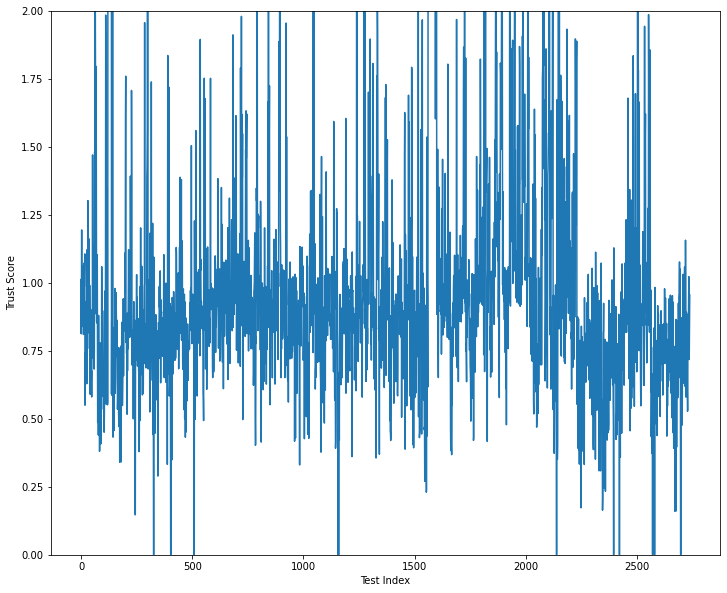

In [54]:
print(score)
plt.plot(score)
plt.ylim(0,2)
plt.ylabel('Trust Score')
plt.xlabel('Test Index')
plt.show()

# Counterfactuals with Prototypes


In [55]:
'''from alibi.explainers import CounterfactualProto
X = test_x[0].reshape((1,) + test_x[0].shape)
shape = X.shape
beta = .01
c_init = 1.
c_steps = 5
max_iterations = 500
rng = (0., 1.)  # scale features between -1 and 1
rng_shape = shape
feature_range = ((np.ones(rng_shape) * rng[0]).astype(np.float32),
                 (np.ones(rng_shape) * rng[1]).astype(np.float32))
                 '''

'from alibi.explainers import CounterfactualProto\nX = test_x[0].reshape((1,) + test_x[0].shape)\nshape = X.shape\nbeta = .01\nc_init = 1.\nc_steps = 5\nmax_iterations = 500\nrng = (0., 1.)  # scale features between -1 and 1\nrng_shape = shape\nfeature_range = ((np.ones(rng_shape) * rng[0]).astype(np.float32),\n                 (np.ones(rng_shape) * rng[1]).astype(np.float32))\n                 '

In [56]:
'''cf = CounterfactualProto(model,
                         shape,
                         beta=beta,
                         cat_vars={i:2 for i in range(2048)},
                         ohe=True,  # OHE flag
                         max_iterations=max_iterations,
                         feature_range=feature_range,
                         c_init=c_init,
                         c_steps=c_steps
                        )'''

'cf = CounterfactualProto(model,\n                         shape,\n                         beta=beta,\n                         cat_vars={i:2 for i in range(2048)},\n                         ohe=True,  # OHE flag\n                         max_iterations=max_iterations,\n                         feature_range=feature_range,\n                         c_init=c_init,\n                         c_steps=c_steps\n                        )'

# Tanimoto similarity

In [79]:
from rdkit import DataStructs

def similarity(fp1, fp2):
  return DataStructs.FingerprintSimilarity(fp1,fp2, metric=DataStructs.DiceSimilarity)

similarities = [similarity(Cilostazol_fp, x) for x in list(test_df['fingerprint'])]
predictions = tf.math.round(model.predict(test_x)).numpy().astype('int').flatten()
test_df['predictions'] = predictions
test_df['similarities'] = similarities
test_df = test_df.sort_values(by=['similarities'], ascending=False)
inactive_df = test_df.loc[test_df['Class'] != 'Active']

print(inactive_df.head(20))

                                                   SMILES     Class  Class code  Type                                              mols                                        fingerprint                                           bit_info  predictions  similarities
ID                                                                                                                                                                                                                                                                      
Tr1122            COc1ccc(cc1)S(=O)(=O)N2CCC(CC2)N3CCCCC3  Inactive           1  test  <rdkit.Chem.rdchem.Mol object at 0x7f57478295d0>  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  {2: ((20, 2),), 319: ((5, 1),), 322: ((2, 1),)...            1      0.355556
Tr1713              Cc1cccc(OCC(=O)N2CCC(CC2)N3CCCCCC3)c1  Inactive           1  test  <rdkit.Chem.rdchem.Mol object at 0x7f574796a8f0>  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  {2: ((19, 2), (20

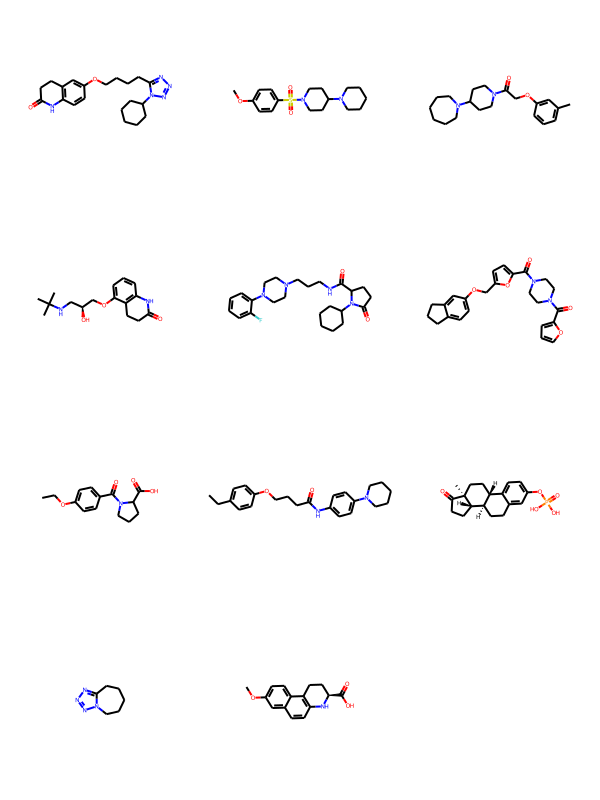

In [82]:
Draw.MolsToGridImage([Cilostazol_mol] + list(inactive_df['mols'])[0:10])